<a href="https://colab.research.google.com/github/flediak/genIAL/blob/main/genIAL_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# step-by-step example for modeling IA in a cosmological simulation using genIAL

genIAL generates intrinsic galaxy alignment (IA) by assigning intrinsic shapes and orientations to galaxies from a cosmological simulation based on the galaxy redshift, photometric properties, as well as the orientation and angular momentum of the dark matter host haloes.

The IA modeling is done in three steps:
- assigning 3D galaxy axis ratios
- assigning 3D galaxy orientations
- projecting 3D galaxies along the observed line of sight to obtain the 2D ellipticities

This notebook shows how to run genIAL on input data from the MICE simulation.
See https://arxiv.org/abs/2206.14219 for more details on the modeling.

# 1) clone genIAL repository and import libraries

In [ ]:
! git clone https://github.com/flediak/genIAL.git

Cloning into 'genIAL'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 32 (delta 13), reused 9 (delta 3), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [ ]:
cd genIAL

/content/genIAL


In [ ]:
import pkg_resources
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from genial import Galaxy, IntrinsicAlignment

# 2) set IA model parameters

### define u-r color cut
The $u-r=M_u-M_r$ is the color index, defined via the absolute resframe magnitudes $M_u$ and $M_r$. This cut is used to define the color-type of a given galaxy (red or blue). In this verison of the IA model the color-type defines which parameters are used to model galaxy shapes as well as galaxy misalignment. The value for the color-cut is set to reproduce the fraction of red and blue galaxies in the COSMOS-15 catalogue (Laigle et al. 2016) in MICE for galaxies with apparent magnitudes of $m_i<24$.

In [ ]:
ia_ur_cut = 0.94

### set parameters for galaxy misalignemnt
These parameters define the linear magnitude dependence of the misalignment parameter $\sigma (M_r)$ used for the IA modeling in MICE.

In [ ]:
p_cr = [0.65, 0,0] # red centrals 
p_sr = [0.7, -7.7] # red satellites
p_cb = [2.0, 0.0] # blue centrals
p_sb = [2.0, 0.0] # blue satellites

### read parameters for modeling galaxy 3D axis ratios from input table

Download table:

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1F6-XasMtdVk6BuR5TN8GnMc-AiUgu3Mf' -O ia_shape_parameters.csv

--2022-07-13 10:51:37--  https://docs.google.com/uc?export=download&id=1F6-XasMtdVk6BuR5TN8GnMc-AiUgu3Mf
Resolving docs.google.com (docs.google.com)... 74.125.23.102, 74.125.23.139, 74.125.23.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.23.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-5k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gvsep547gmbmjke5bgc5kggcbsdrhh1v/1657709475000/07375493793059712153/*/1F6-XasMtdVk6BuR5TN8GnMc-AiUgu3Mf?e=download&uuid=45449b44-e969-479d-bfaa-0ee3b039722d [following]
--2022-07-13 10:51:39--  https://doc-10-5k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gvsep547gmbmjke5bgc5kggcbsdrhh1v/1657709475000/07375493793059712153/*/1F6-XasMtdVk6BuR5TN8GnMc-AiUgu3Mf?e=download&uuid=45449b44-e969-479d-bfaa-0ee3b039722d
Resolving doc-10-5k-docs.googleusercontent.com (doc-10-5k-docs.googleusercontent.com)... 74.125.204.132, 2404:6800:4008

#### Read table into pandas dataframe

In [ ]:
with open('ia_shape_parameters.csv') as fd:

    shape_params = pd.read_csv(fd, header=0)
    
    #set color IDs for red and blue in the input table to those used in the galaxy class
    shape_params.loc[shape_params['gal_color']==2.0, 'gal_color'] = Galaxy.Color.BLUE.value
    shape_params.loc[shape_params['gal_color']==0.0, 'gal_color'] = Galaxy.Color.RED.value
    
    #put table into format that can be passed to the IA class
    shape_params = shape_params.set_index(['gal_color', 'z', 'mag']).sort_index()[['q_mean', 'r_mean', 'sigma']]

# 3) read input galaxy catalogue

Required columns of input file:
- x_gal, y_gal, z_gal (galaxy positions)
- x_halo, y_halo, z_halo (halo positions)
- Ax_halo, Ay_halo, Az_halo (halo major axis components)
- Cx_halo, Cy_halo, Cz_halo (halo minor axis components)
- Jx_halo, Jy_halo, Jz_halo (halo angular momentum components)
- u- and r-band absolute restframe magnitudes
- flag_central (some flag, defining a galaxy as central or satellite)


Here we use an input file generated from the MICE IA catalog on
https://cosmohub.pic.es, using this SQL query:

SELECT `x_gal`, `y_gal`, `z_gal`, `flag_central`, `true_redshift_gal`, `cfht_u_abs_mag`, `subaru_r_abs_mag`,`x_halo`, `y_halo`, `z_halo`, `ax_halo`, `ay_halo`, `az_halo`, `cx_halo`, `cy_halo`, `cz_halo`, `jx_halo`, `jy_halo`, `jz_halo` FROM mice2_ia_20210203_c WHERE true_redshift_gal < 0.2 AND subaru_r_abs_mag - 0.8 * (ATAN(1.5 * true_redshift_gal) - 0.1489) < -21

Downlad catalogue:


In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1CqboAhfDqNraH-V0WW3D7DX5ctMc17tl' -O input_file.parquet

--2022-07-13 10:51:39--  https://docs.google.com/uc?export=download&id=1CqboAhfDqNraH-V0WW3D7DX5ctMc17tl
Resolving docs.google.com (docs.google.com)... 142.251.8.138, 142.251.8.113, 142.251.8.139, ...
Connecting to docs.google.com (docs.google.com)|142.251.8.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-5k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2mrg2eivpkjb9u62s4ha8r44i2spbueg/1657709475000/07375493793059712153/*/1CqboAhfDqNraH-V0WW3D7DX5ctMc17tl?e=download&uuid=2d629045-cb52-4a26-8ce7-5e0a03d785a3 [following]
--2022-07-13 10:51:42--  https://doc-0c-5k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2mrg2eivpkjb9u62s4ha8r44i2spbueg/1657709475000/07375493793059712153/*/1CqboAhfDqNraH-V0WW3D7DX5ctMc17tl?e=download&uuid=2d629045-cb52-4a26-8ce7-5e0a03d785a3
Resolving doc-0c-5k-docs.googleusercontent.com (doc-0c-5k-docs.googleusercontent.com)... 74.125.204.132, 2404:6800:4008

#### Read catalogue into pandas dataframe

In [ ]:
cat = pd.read_parquet('input_file.parquet')#.iloc[0:10000]

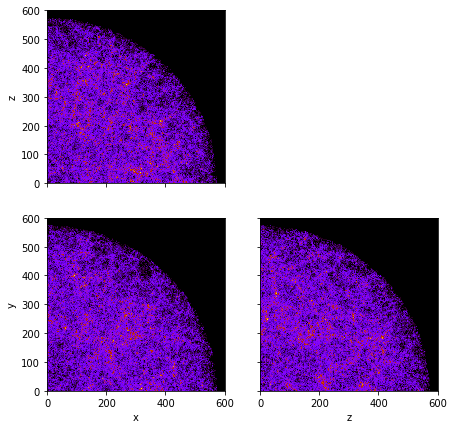

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(7,7), sharex=True, sharey=True)

cmap='gnuplot'

lbins=np.linspace(0,600,200)


ax[0,0].hist2d(cat.x_gal, cat.z_gal, bins=[lbins,lbins], cmap=cmap)
ax[1,0].hist2d(cat.x_gal, cat.y_gal, bins=[lbins,lbins], cmap=cmap)
ax[1,1].hist2d(cat.z_gal, cat.y_gal, bins=[lbins,lbins], cmap=cmap)
ax[0,1].axis('off')

ax[0,0].set_ylabel('z')
ax[1,0].set_ylabel('y')
ax[1,0].set_xlabel('x')
ax[1,1].set_xlabel('z')

plt.show()

### define blue / red IDs

In [ ]:
#### use this color index for red blue definitions
ia_ur = cat['cfht_u_abs_mag'] - cat['subaru_r_abs_mag']

# Apply color cut to define color
ia_color = np.where(
    ia_ur < ia_ur_cut,
    Galaxy.Color.BLUE.value,
    Galaxy.Color.RED.value
).astype('i1')

### define satellite / central IDs

In [ ]:
ia_kind = np.where(
    cat.flag_central == 0,
    Galaxy.Kind.CENTRAL.value,
    Galaxy.Kind.SATELLITE.value
).astype('i1')

# 4) assign 3D galaxy shapes
### instance of IA class

In [ ]:
ia = IntrinsicAlignment(shape_params)

### set 3D axis ratios q=B/A, s=C/A

---



In [ ]:
cat['q_gal'], cat['s_gal'] = ia.axis_ratio(ia_color, cat['true_redshift_gal'].values, cat['subaru_r_abs_mag'].values)

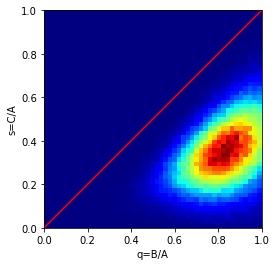

In [ ]:
sq_bins = np.linspace(0,1,50)
plt.hist2d(cat.q_gal, cat.s_gal,bins=sq_bins, cmap='jet')
plt.plot(sq_bins, sq_bins, c='r')
plt.axis('square')
plt.xlabel('q=B/A')
plt.ylabel('s=C/A')
plt.show()

# 5) assign 3D galaxy orientations
### make sure that vectors of halo major and minor axis and angular momentum are normalized

In [ ]:
cat['a_halo'] = ((cat['ax_halo']**2 + cat['ay_halo']**2 + cat['az_halo']**2)**0.5)
cat['c_halo'] = ((cat['cx_halo']**2 + cat['cy_halo']**2 + cat['cz_halo']**2)**0.5)
cat['j_halo'] = ((cat['jx_halo']**2 + cat['jy_halo']**2 + cat['jz_halo']**2)**0.5)

cat['ax_halo'] = (cat['ax_halo'] / cat['a_halo'])
cat['ay_halo'] = (cat['ay_halo'] / cat['a_halo'])
cat['az_halo'] = (cat['az_halo'] / cat['a_halo'])

cat['cx_halo'] = (cat['cx_halo'] / cat['c_halo'])
cat['cy_halo'] = (cat['cy_halo'] / cat['c_halo'])
cat['cz_halo'] = (cat['cz_halo'] / cat['c_halo'])

cat['jx_halo'] = (cat['jx_halo'] / cat['j_halo'])
cat['jy_halo'] = (cat['jy_halo'] / cat['j_halo'])
cat['jz_halo'] = (cat['jz_halo'] / cat['j_halo'])

### set up input arrays

In [ ]:
vg = np.array([
    cat['x_gal'].values,
    cat['y_gal'].values,
    cat['z_gal'].values,
]).T

vh = np.array([
    cat['x_halo'].values,
    cat['y_halo'].values,
    cat['z_halo'].values,
]).T
    
Ah = np.array([
    cat['ax_halo'].values,
    cat['ay_halo'].values,
    cat['az_halo'].values,
]).T

Ch = np.array([
    cat['cx_halo'].values,
    cat['cy_halo'].values,
    cat['cz_halo'].values,
]).T
  
Jh = np.array([
    cat['jx_halo'].values,
    cat['jy_halo'].values,
    cat['jz_halo'].values,
]).T

### set initial orientations

In [ ]:
Ag, Cg = ia.orientations(ia_kind, ia_color, vg, vh, Ah, Ch, Jh)

### get galaxy misalignment parameter $\sigma$

In [ ]:
cat['sigma'] = ia.misalignment_parameters_v0(
    ia_kind, ia_color, cat['subaru_r_abs_mag'].values.T, p_cr, p_cb, p_sr, p_sb
)

### randomly misalign initial orientations

In [ ]:
Ar,Cr = ia.randomize(Ag, Cg, cat['sigma'].values)

# 6) 2D ellipticities of projected 3D galaxies
Note: the observer is assumed to be located at x,y,z= 0,0,0

### set up input arrays

In [ ]:
vg = np.array([
    cat['x_gal'].values,
    cat['y_gal'].values,
    cat['z_gal'].values,
]).T

Ag = np.array([
    Ar[:, 0],
    Ar[:, 1],
    Ar[:, 2],
]).T

Cg = np.array([
    Cr[:, 0],
    Cr[:, 1],
    Cr[:, 2],
]).T

qg = cat['q_gal'].values.T
sg = cat['s_gal'].values.T

In [ ]:
cat['eps1_gal'], cat['eps2_gal'] = ia.ellipticity(vg, qg, sg, Ag, Cg)

# 7) validation plots

### 2D axis ratios

In [ ]:
eps_abs = (cat.eps1_gal**2 + cat.eps2_gal**2)**0.5
cat['q2d_gal'] = (1-eps_abs) / (1+eps_abs)

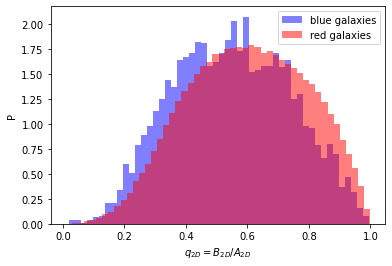

In [ ]:
blues = ia_color == Galaxy.Color.BLUE
reds = ia_color == Galaxy.Color.RED

plt.hist(cat.iloc[blues].q2d_gal, bins=50, density=True, alpha=0.5, color='b', label='blue galaxies')
plt.hist(cat.iloc[reds].q2d_gal, bins=50, density=True, alpha=0.5, color='r', label='red galaxies')

plt.legend()
plt.xlabel(r'$q_{2D} = B_{2D} / A_{2D}$')
plt.ylabel('P')
plt.show()

### ellipses on the sky

In [ ]:
### 2D position angles
cat['alpha_gal'] = 0.5*np.arctan2(cat.eps2_gal,cat.eps1_gal)*180/np.pi

# angular coordinates
cat['ra_gal'] = np.arctan2(cat.x_gal,cat.y_gal)*180/np.pi
cat['dec_gal'] = np.arcsin(cat.z_gal/(cat.x_gal**2 + cat.y_gal**2 + cat.z_gal**2)**0.5)*180/np.pi

In [ ]:
#select angular patch on a redshift shell
z_min, z_max = 0.19, 0.2
ra_min, ra_max = 0,40
dec_min, dec_max = 0,20

select_z = (z_min < cat.true_redshift_gal) & (cat.true_redshift_gal < z_max).values
select_ra = ((ra_min < cat.ra_gal) & (cat.ra_gal < ra_max)).values
select_dec = ((dec_min < cat.dec_gal) & (cat.dec_gal < dec_max)).values

patch = cat[select_z & select_ra & select_dec]

In [ ]:
from matplotlib.patches import Ellipse

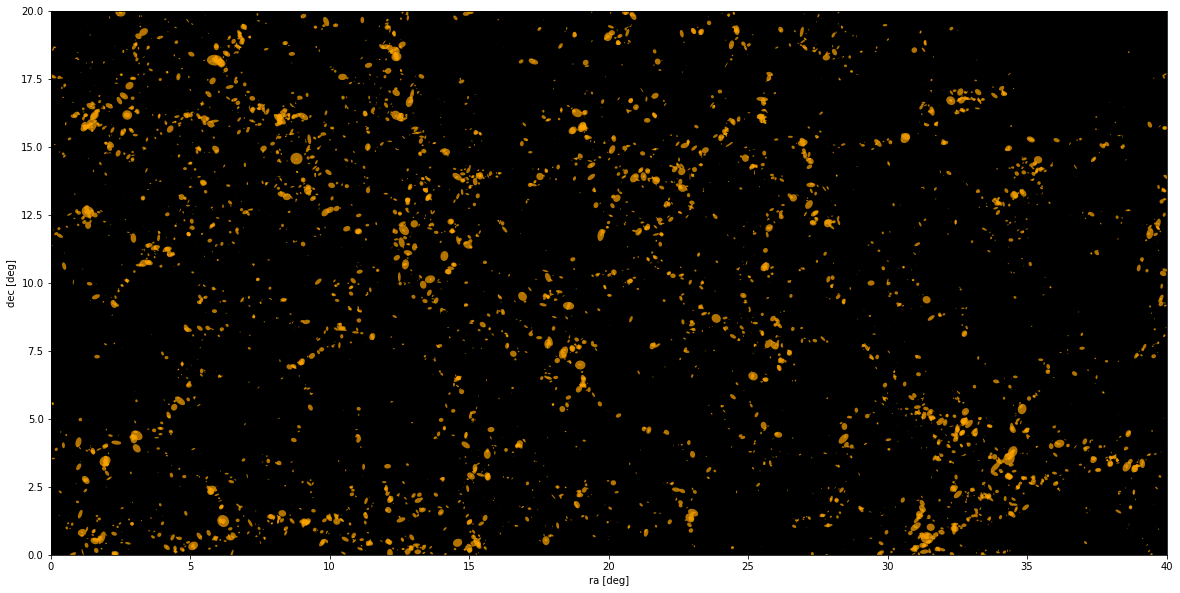

In [ ]:
radec_ratio = (ra_max-ra_min)/(dec_max-dec_min)

fig, ax = plt.subplots(figsize=(10*radec_ratio,10))

for i in range(len(patch)):

  x = patch.iloc[i].ra_gal
  y = patch.iloc[i].dec_gal
  angle=90-patch.iloc[i].alpha_gal
  q = patch.iloc[i].q2d_gal
  mag_scale = patch.iloc[i].subaru_r_abs_mag/patch.subaru_r_abs_mag.max()-1

  A = 5*mag_scale
  B = A*q
  
  elli = Ellipse((x,y), B, A ,angle)
  elli.set_facecolor('orange')
  elli.set_alpha(0.7)
 
  ax.add_artist(elli)

ax.set_xlim(ra_min, ra_max)
ax.set_ylim(dec_min, dec_max)

ax.set_facecolor('k')
ax.set_xlabel('ra [deg]')
ax.set_ylabel('dec [deg]')

plt.show()

# 8) compute 3D alignment statistics

### install covo

> Indented block



In [ ]:
cd ..

/content


In [ ]:
! git clone https://flediak@bitbucket.org/flediak/covo.git

Cloning into 'covo'...
Receiving objects: 100% (369/369), 13.85 MiB | 20.32 MiB/s, done.
Resolving deltas: 100% (220/220), done.


In [ ]:
cd covo/src

/content/covo/src


In [ ]:
!make

g++ -c main.cpp -std=c++11 -O3
g++ -c parameters.cpp -std=c++11 -O3
g++ -c directory.cpp -std=c++11 -O3
g++ -c healpix.cpp -std=c++11 -O3
g++ -c catalogue.cpp -std=c++11 -O3
g++ -c correlation.cpp -std=c++11 -O3
g++ -o ../covo main.o parameters.o directory.o healpix.o catalogue.o  correlation.o


In [ ]:
cd ..

/content/covo


### write input file for covo

In [ ]:
fname_cat_shape = 'catalogues/ia_cat_shape.csv'
fname_cat_dense = 'catalogues/ia_cat_dense.csv'

cat[['ax_gal_rand', 'ay_gal_rand', 'az_gal_rand']] = Ar
cat[['cx_gal_rand', 'cy_gal_rand', 'cz_gal_rand']] = Cr

columns_shape = ['x_gal', 'y_gal', 'z_gal', 'ax_gal_rand', 'ay_gal_rand', 'az_gal_rand', 'cx_gal_rand', 'cy_gal_rand', 'cz_gal_rand']
columns_dense = ['x_gal', 'y_gal', 'z_gal']

cat[columns_shape].to_csv(fname_cat_shape, index=None, header=None, compression=None, sep=",")
cat[columns_dense].to_csv(fname_cat_dense, index=None, header=None, compression=None, sep=",")

### run covo

In [ ]:
mkdir results

In [ ]:
! ./covo covo.params_lightcone catalogues/ia_cat_shape.csv catalogues/ia_cat_dense.csv results/eta.csv


# ================ PARAMETERS ================
# fname_cat_1: catalogues/ia_cat_shape.csv
# fname_cat_2: catalogues/ia_cat_dense.csv
# fname_out: input
# delim_in: ,
# delim_out: ,
# header_out: 1

# mode: shell
# auto_limits: 1
# nside: 8
# nrad: 2

# columns in input catalogue: 
# - position vector: 0 1 2 
# - vector a: 3 4 5 
# - vector b: 6 7 8 

# r_min = 0.1
# r_max = 40
# numb_bin = 20
# lg_bins = 1

# expip = 1

# r12_v1a = 1
# r12_v1b = 1
# r12_v2a = 0
# r12_v2b = 0
# v1a_v2a = 0
# v1b_v2b = 0
# v1a_v2b = 0
# v1b_v2a = 0

# make_rand = 0
# ============================================


# ==== read data ====
# size of catalogue 1: 229131

# size of catalogue 2: 229131

# min. / max. coordinates in catalogue 1
# 215.658 < r < 575.975
# 0.0802959 < theta < 90
# 0.00128311 < phi < 89.9944

# min. / max. coordinates in catalogue 2
# 215.658 < r < 575.975
# 0.0802959 < theta < 90
# 0.00128311 < phi < 89.9944

# cut out overlap region between cat 1 and cat 2

# make subsamples
# num

### read data, plot results

In [ ]:
eta = pd.read_csv('./results/eta.csv')

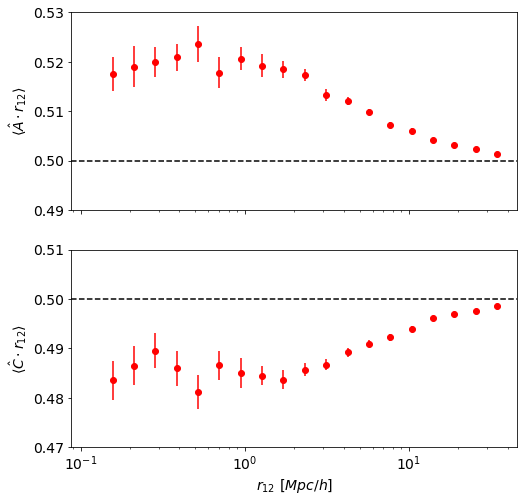

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(8,8), sharex=True, sharey=False)

fontsize = 14

ax[0].errorbar(eta.r, eta.r12_v1a, eta.r12_v1a_std, c='r', marker='o', ls='')
ax[1].errorbar(eta.r, eta.r12_v1b, eta.r12_v1b_std, c='r', marker='o', ls='')


ax[-1].set_xlabel('$r_{12} \ [Mpc/h]$', fontsize = fontsize)

ax[0].set_ylabel(r'$\langle \hat{A} \cdot r_{12} \rangle$',fontsize=fontsize)
ax[1].set_ylabel(r'$\langle \hat{C} \cdot  r_{12} \rangle$',fontsize=fontsize)
    
ax[0].set_ylim(0.49,0.53)
ax[1].set_ylim(0.47,0.51)

for j in range(2):
    ax[j].set_xscale('log')
    ax[j].tick_params(axis='both',labelsize=fontsize)
    ax[j].axhline(y=0.5, c='k', linestyle='--')